## Faithful Data

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from scipy.stats import gaussian_kde

# Load the MATLAB .mat file
mat_file = "faithful_RGM_result_2Revision.mat"
data = loadmat(mat_file)

# Extract necessary variables
Y_faithful = data["Y_faithful"]  # Original Old Faithful geyser data
gamma_mc = data["gamma_mc"]  # Cluster assignments over MCMC
Gamma_mc = data["Gamma_mc"]  # Cluster means
K_mc = data["K_mc"].flatten()  # Number of clusters over iterations
gamma_mc = gamma_mc[0]  # Keep only the first chain
# Extract the last MCMC iteration
Gamma_mc = Gamma_mc[:, :, :, -1]  # Extracts the last MCMC iteration


print("Loaded MATLAB file successfully!")
print(f"Y_faithful shape: {Y_faithful.shape}")
print(f"gamma_mc shape: {gamma_mc.shape}")
print(f"Gamma_mc shape: {Gamma_mc.shape}")
print(f"K_mc shape: {K_mc.shape}")

Loaded MATLAB file successfully!
Y_faithful shape: (271, 2)
gamma_mc shape: (271, 2000)
Gamma_mc shape: (2, 2, 271)
K_mc shape: (2000,)


## Predictive Density under RGM

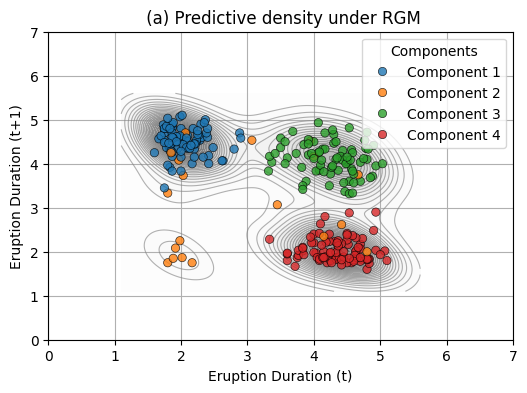

In [4]:
from scipy.stats import gaussian_kde


# Scatter plot of geyser eruption data
plt.figure(figsize=(6, 4))

# Compute a higher resolution KDE with increased bandwidth for smoother contours
kde = gaussian_kde(Y_faithful.T, bw_method=0.3)  # Increased bandwidth for smoother density

# Create a wider grid for the contour plot
xgrid = np.linspace(Y_faithful[:, 0].min() - 0.5, Y_faithful[:, 0].max() + 0.5, 200)
ygrid = np.linspace(Y_faithful[:, 1].min() - 0.5, Y_faithful[:, 1].max() + 0.5, 200)
X, Y = np.meshgrid(xgrid, ygrid)
positions = np.vstack([X.ravel(), Y.ravel()])
density = kde(positions).reshape(X.shape)

# Plot contour density with stronger contrast
contour = plt.contourf(X, Y, density, levels=30, cmap="Greys", alpha=0.5)  # Adjusted alpha for more visibility
plt.contour(X, Y, density, levels=30, colors="grey", linewidths=0.8, alpha=0.6)  # Sharpen contour lines

# Get final cluster assignments (last iteration)
final_clusters = gamma_mc[:, -1]  # Assuming last column has final assignments

# Convert cluster numbers to categorical component names
unique_clusters = np.unique(final_clusters)
# Sort unique clusters to maintain order
sorted_clusters = np.sort(unique_clusters)
cluster_mapping = {cluster: f"Component {i+1}" for i, cluster in enumerate(sorted_clusters)}

# Convert final cluster assignments to ordered component labels
final_cluster_labels = np.array([cluster_mapping[cluster] for cluster in final_clusters])

# Scatter plot of observations colored by clusters
sns.scatterplot(x=Y_faithful[:, 0], y=Y_faithful[:, 1], hue=final_cluster_labels,
                hue_order=[f"Component {i+1}" for i in range(len(sorted_clusters))],  # Ensure legend order
                palette="tab10", edgecolor="black", alpha=0.8, zorder=3)


plt.xlim(0, 7)
plt.ylim(0, 7)
plt.xlabel("Eruption Duration (t)")
plt.ylabel("Eruption Duration (t+1)")
plt.title(" (a) Predictive density under RGM")
plt.legend(title="Components", loc="upper right")
plt.grid(True)
plt.show()

([<matplotlib.axis.XTick at 0x157ed4740>,
 [Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7')])

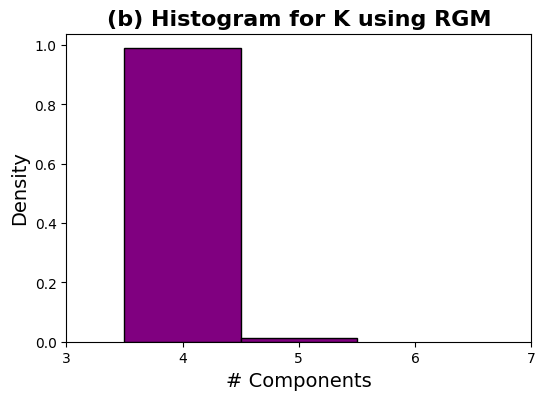

In [3]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

mat_file = "faithful_RGM_result_2Revision.mat"
mat_data = loadmat(mat_file)

# Extract relevant variables
K_mc = mat_data["K_mc"].flatten()  # Posterior samples of the number of clusters
B = int(mat_data["B"].flatten()[0])  # Burn-in period
nmc = int(mat_data["nmc"].flatten()[0])  # Number of posterior samples

# Select samples after burn-in
sample_ind = K_mc[B:]  # Only use post-burn-in samples

# Plot the histogram
plt.figure(figsize=(6, 4))
plt.hist(sample_ind, bins=np.arange(min(sample_ind)-0.5, max(sample_ind)+1.5, 1), 
         color="purple", edgecolor="black", density=True)
plt.xlabel("# Components", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.title("(b) Histogram for K using RGM", fontsize=16, fontweight="bold")
plt.xlim(3, 7)  # Set the x-axis range from 3 to 7
plt.xticks([3, 4, 5, 6, 7])  # Force x-axis to show only whole numbers

Figure (b) shows that the RGM model exhibits a highly concentrated posterior distribution of K=4. This indicates a great certainty about the number of clusters. It also aligns precisely with the visual structure observed in the cluster plot (Figure (a)), confirming that RGM correctly captures the true number of clusters in the dataset. The sharp peak and lack of spread demonstrate the robustness and model parsimony of the RGM approach.

## DPP Mixture Model

### load data

In [7]:
import pandas as pd
import numpy as np

# Load 2D adjacent-pair data directly
df = pd.read_csv("faithful_data.csv")

# Check the column names
print(df.columns)

# Convert to NumPy array
y = df.values
Num, D = y.shape
print(f"Dataset dimensions: {Num} observations, {D} features")
print(y[:5])


Index(['duration_t', 'duration_t+1'], dtype='object')
Dataset dimensions: 271 observations, 2 features
[[3.6   1.8  ]
 [1.8   3.333]
 [3.333 2.283]
 [2.283 4.533]
 [4.533 2.883]]


### compute eigenvalues

In [39]:
import numpy as np

Num, D = y.shape
Smatrix = np.zeros((D, D))

for i in range(Num):
    Smatrix += np.outer(y[i], y[i])

Smatrix /= Num
eigenvalues, Eigenvector = np.linalg.eigh(Smatrix)

### functions for DPP

In [ ]:
import numpy as np
from numpy.random import uniform, beta, choice, binomial
from scipy.stats import (
    multivariate_normal as dmvnorm,
    gamma,
    bernoulli,
    dirichlet,
    wishart,
    beta
)
from sklearn.cluster import KMeans
from collections import Counter

# Define hyperparameters
hyper = {
    "r": 4,
    "l": 4,
    "delta": 1,
    "sigmapro": 0.2,
    "theta": 7
}

# Define MCMC parameters
Niter = 2000
burn_in = 1000
lag = 1
Num = 271  # Number of data points
D = 2  # Dimensionality of the data

# Initialize MCMC storage
mcmc = {
    "K": np.zeros(Niter, dtype=int),
    "z": np.zeros((Niter, Num), dtype=int),
    "w": np.zeros((Niter, Num)),
    "mu": np.zeros((Niter, Num, D)),
    "lambda": np.zeros((Niter, Num, D))
}

np.random.seed(2)
mcmc["K"][0] = 10
kmeans = KMeans(n_clusters=mcmc["K"][0], n_init=10, random_state=2).fit(y)

mcmc["z"][0, :] = kmeans.labels_
mcmc["w"][0, :mcmc["K"][0]] = np.bincount(kmeans.labels_) / Num
mcmc["mu"][0, :mcmc["K"][0], :] = kmeans.cluster_centers_
mcmc["lambda"][0, :mcmc["K"][0], :] = np.full((mcmc["K"][0], D), 2)


# Define grid for predictive density estimation
x1 = np.linspace(0, 6, 100)
x2 = np.linspace(0, 6, 100)
X1, X2 = np.meshgrid(x1, x2)

# Initialize predictive density matrix
p_pred_DPP = np.zeros((len(x1), len(x2)))

# Simulated number of MCMC iterations
B = 1000  # Burn-in
nmc = 1000  # Number of samples
mcmc_samples = 2000  # Total MCMC samples

def update_Sigma(lambd, K, Eigenvector):
    D = Eigenvector.shape[0]
    Sigma = np.zeros((D, D, K))
    for k in range(K):
        Sigma[:, :, k] = Eigenvector @ np.diag(lambd[k]) @ Eigenvector.T
    return Sigma


def update_zK(K, mu, lambd, w, y, Eigenvector):
    Num = y.shape[0]
    Sigma = update_Sigma(lambd, K, Eigenvector)
    z = np.zeros(Num, dtype=int)
    
    for i in range(Num):
        den = np.zeros(K)
        for k in range(K):
            den[k] = w[k] * multivariate_normal.pdf(y[i], mean=mu[k], cov=Sigma[:, :, k])
        
        den = den / np.sum(den)  # Normalize probabilities
        z[i] = np.random.choice(np.arange(K), p=den)
    
    # Identify existing clusters
    unique_z, counts = np.unique(z, return_counts=True)
    exist_z = unique_z
    id_to_remove = np.setdiff1d(np.arange(K), exist_z)
    
    if len(id_to_remove) > 0:
        mu = np.delete(mu, id_to_remove, axis=0)
        w = np.delete(w, id_to_remove, axis=0)
        lambd = np.delete(lambd, id_to_remove, axis=0)
    
    Knew = len(np.unique(z))
    
    # Re-label z sequentially
    new_labels = {old_label: new_label for new_label, old_label in enumerate(np.unique(z))}
    z = np.array([new_labels[label] for label in z])
    
    return {
        'z': z,
        'K': Knew,
        'mu': mu,
        'w': w,
        'lambda': lambd
    }

import numpy as np
from scipy.stats import dirichlet

def update_w(K, z, delta):
    _, counts = np.unique(z, return_counts=True)
    alpha = delta + counts
    w = dirichlet(alpha).rvs()[0]
    return w


def update_lambda(mu, K, z, y, hyper, Eigenvector):
    D = y.shape[1]
    lambda_mat = np.zeros((K, D))

    for k in range(K):
        Sm = np.zeros((D, D))
        id_k = np.where(z == k)[0]
        for i in id_k:
            diff = (y[i] - mu[k]).reshape(-1, 1)
            Sm += diff @ diff.T
        shape_param = (len(id_k) + hyper['r'] + 1) / 2
        rate_param = (hyper['l'] + np.diag(Eigenvector.T @ Sm @ Eigenvector)) / 2
        from scipy.stats import gamma
        lambda_mat[k, :] = 1 / gamma(a=shape_param, scale=1/rate_param).rvs()

    return lambda_mat

def cov_matrix(mu, K, theta):
    c = np.zeros((K, K))
    for i in range(K):
        for j in range(K):
            c[i, j] = np.exp(-np.sum((mu[i, :] - mu[j, :]) ** 2 / theta))
    return c

def update_mu(K, mu, z, y, lambda_mat, hyper, Eigenvector, theta):
    Sigma = update_Sigma(lambda_mat, K, Eigenvector)
    D = y.shape[1]
    for k in range(K):
        covm = cov_matrix(mu, K, theta)
        invc = np.linalg.inv(covm[np.arange(K) != k][:, np.arange(K) != k])
        muold = mu[k, :].copy()
        munew = multivariate_normal.rvs(mean=mu[k, :], cov=hyper['sigmapro']**2 * np.eye(D))
        fnew = np.exp(-np.sum((munew - mu[np.arange(K) != k]) ** 2 / theta**2, axis=1))
        tmp1 = y[z == k] - munew
        tmp2 = y[z == k] - muold
        num = np.diag(tmp1 @ np.linalg.inv(Sigma[:, :, k]) @ tmp1.T)
        den = np.diag(tmp2 @ np.linalg.inv(Sigma[:, :, k]) @ tmp2.T)
        ratio = ((1 - fnew @ invc @ fnew) / (1 - covm[k, np.arange(K) != k] @ invc @ covm[k, np.arange(K) != k])) * \
                 np.exp(0.5 * np.sum(den) - 0.5 * np.sum(num))
        if uniform(0, 1) < ratio:
            mu[k, :] = munew

    return mu

def update_rj(K, lambd, mu, w, z, y, hyper, Eigenvector):
    Num, D = y.shape
    Sigma = update_Sigma(lambd, K, Eigenvector)
    covold = cov_matrix(mu, K, hyper['theta'])

    temp = np.array([dmvnorm.pdf(y[i], mean=mu[z[i]], cov=Sigma[:, :, z[i]]) for i in range(Num)])
    Likelihood_old = np.sum(np.log(temp))

    if K == 1 or uniform() < 0.5:
        Knew = K + 1
        alpha = beta.rvs(a=1, b=1)
        beta_vec = beta.rvs(a=1, b=1, size=D)
        u = beta.rvs(a=2, b=2, size=D) * choice([-1, 1], D)
        id_choice = choice(K)

        znew = np.array([zi if zi <= id_choice else zi - 1 for zi in z])
        id_label = np.where(z == id_choice)[0]
        nid = len(id_label)

        w1, w2 = w[id_choice] * alpha, w[id_choice] * (1 - alpha)
        wnew = np.concatenate((np.delete(w, id_choice), [w1, w2]))
        wnew = wnew / np.sum(wnew)  # Ensure weights sum to 1

        temp1 = (np.sqrt(lambd[id_choice]) * u) @ Eigenvector.T
        mu1 = mu[id_choice] - np.sqrt((1 - alpha) / alpha) * temp1
        mu2 = mu[id_choice] + np.sqrt(alpha / (1 - alpha)) * temp1
        munew = np.vstack((np.delete(mu, id_choice, axis=0), mu1, mu2))

        lambd1 = beta_vec * (1 - u**2) / alpha * lambd[id_choice]
        lambd2 = (1 - beta_vec) * (1 - u**2) * lambd[id_choice] / (1 - alpha)
        lambdanew = np.vstack((np.delete(lambd, id_choice, axis=0), lambd1, lambd2))
        Sigmanew = update_Sigma(lambdanew, Knew, Eigenvector)

        p1 = w1 * dmvnorm.pdf(y[id_label], mu1, Sigmanew[:, :, Knew - 2])
        p2 = w2 * dmvnorm.pdf(y[id_label], mu2, Sigmanew[:, :, Knew - 1])
        prob = np.divide(p1, p1 + p2, out=np.zeros_like(p1), where=(p1+p2)!=0)
        tmp2 = bernoulli.rvs(prob)

        znew[id_label[tmp2 == 1]] = Knew - 1
        znew[id_label[tmp2 == 0]] = Knew
        n1, n2 = np.sum(tmp2), nid - np.sum(tmp2)

        # Ensure znew does not exceed valid indices
        znew = np.clip(znew, 0, Knew - 1)

        # Ensure `munew` and `Sigmanew` match Knew
        munew = munew[:Knew]
        Sigmanew = Sigmanew[:, :, :Knew]

        # Compute likelihood safely
        tempnew = np.array([dmvnorm.pdf(y[i], munew[znew[i]], Sigmanew[:, :, znew[i]]) for i in range(Num)])

        Likelihood_new = np.sum(np.log(tempnew))

        ratio_like = Likelihood_new - Likelihood_old

        #-np.log(Knew): penalizes large K, 0.5*Knew: further discourages new cluster creation as K grows
        birth_ratio = np.exp(ratio_like - np.log(Knew) - 0.5 * Knew)  *0.5

        if uniform() < birth_ratio:
            return {'K': Knew, 'mu': munew, 'w': wnew, 'lambda': lambdanew, 'z': znew}

    else:
        if K > 1:
            Knew = K - 1
            id_choice = np.sort(choice(K, 2, replace=False))
            id1, id2 = id_choice

            znew = np.array([zi - (zi > id1) - (zi > id2) if zi != id1 and zi != id2 else Knew - 1 for zi in z])
            w1 = w[id1] + w[id2]
            wnew = np.concatenate((np.delete(w, id_choice), [w1]))
            wnew = wnew / np.sum(wnew)  # Normalize



            mu1 = (w[id1] * mu[id1] + w[id2] * mu[id2]) / w1
            munew = np.vstack((np.delete(mu, id_choice, axis=0), mu1))

            alpha = w[id1] / w1
            lambda1 = alpha * lambd[id1] + (1 - alpha) * lambd[id2] + alpha * (1 - alpha) * (mu[id1] - mu[id2])**2

            lambdanew = np.vstack((np.delete(lambd, id_choice, axis=0), lambda1))
            Sigmanew = update_Sigma(lambdanew, Knew, Eigenvector)

            tempnew = np.array([dmvnorm.pdf(y[i], munew[znew[i]], Sigmanew[:, :, znew[i]]) for i in range(Num)])
            Likelihood_new = np.sum(np.log(tempnew))

            ratio_like = Likelihood_new - Likelihood_old

            death_ratio = np.exp(ratio_like + np.log(K)) * 5  # Additional terms should be computed similarly to R code.
            if uniform() < death_ratio:
                return {'K': Knew, 'mu': munew, 'w': np.concatenate((np.delete(w, id_choice), [w1])),
                        'lambda': lambdanew, 'z': znew}

    return {'K': K, 'mu': mu, 'w': w, 'lambda': lambd, 'z': z}


In [41]:
import time

# Assuming y, Eigenvector, hyper, and mcmc structures are already correctly defined

start_time = time.process_time()

for iter in range(1, Niter):  # Python indexing starts at 0
    # Step 1: Update cluster assignments
    tmp = update_zK(
        mcmc["K"][iter-1],
        mcmc["mu"][iter-1, :mcmc["K"][iter-1], :],
        mcmc["lambda"][iter-1, :mcmc["K"][iter-1], :],
        mcmc["w"][iter-1, :mcmc["K"][iter-1]],
        y,
        Eigenvector
    )

    mcmc["K"][iter] = tmp['K']
    mcmc["z"][iter, :] = tmp['z']
    mcmc["mu"][iter, :mcmc["K"][iter], :] = tmp['mu']
    mcmc["w"][iter, :mcmc["K"][iter]] = tmp['w']
    mcmc["lambda"][iter, :mcmc["K"][iter], :] = tmp['lambda']

    # Step 2: Update weights
    mcmc["w"][iter, :mcmc["K"][iter]] = update_w(
        mcmc["K"][iter],
        mcmc["z"][iter, :],
        hyper['delta']
    )

    # Step 3: Update lambda
    mcmc["lambda"][iter, :mcmc["K"][iter], :] = update_lambda(
        mcmc["mu"][iter, :mcmc["K"][iter], :],
        mcmc["K"][iter],
        mcmc["z"][iter, :],
        y,
        hyper,
        Eigenvector
    )

    # Step 4: Update mu
    mcmc["mu"][iter, :mcmc["K"][iter], :] = update_mu(
        mcmc["K"][iter],
        mcmc["mu"][iter, :mcmc["K"][iter], :],
        mcmc["z"][iter, :],
        y,
        mcmc["lambda"][iter, :mcmc["K"][iter], :],
        hyper,
        Eigenvector,
        hyper['theta']
    )

    # Step 5: RJ-MCMC update
    tmp2 = update_rj(
        mcmc["K"][iter],
        mcmc["lambda"][iter, :mcmc["K"][iter], :],
        mcmc["mu"][iter, :mcmc["K"][iter], :],
        mcmc["w"][iter, :mcmc["K"][iter]],
        mcmc["z"][iter, :],
        y,
        hyper,
        Eigenvector
    )

    mcmc["K"][iter] = tmp2['K']
    mcmc["w"][iter, :mcmc["K"][iter]] = tmp2['w']
    mcmc["mu"][iter, :mcmc["K"][iter], :] = tmp2['mu']
    mcmc["lambda"][iter, :mcmc["K"][iter], :] = tmp2['lambda']
    mcmc["z"][iter, :] = tmp2['z']

    if (iter + 1) % 100 == 0:
        print(f"Iteration # {iter + 1}")
        print(f"Number of Components K = {mcmc['K'][iter]}")

elapsed_time = time.process_time() - start_time
print(f"Elapsed Time: {elapsed_time:.2f} seconds")


Iteration # 100
Number of Components K = 6
Iteration # 200
Number of Components K = 5
Iteration # 300
Number of Components K = 5


/var/folders/hm/csp3y_7176zb7m0yky72dwfc0000gn/T/ipykernel_98867/629348082.py:226: RuntimeWarning: divide by zero encountered in log
  Likelihood_new = np.sum(np.log(tempnew))


Iteration # 400
Number of Components K = 4
Iteration # 500
Number of Components K = 4
Iteration # 600
Number of Components K = 4
Iteration # 700
Number of Components K = 4
Iteration # 800
Number of Components K = 4
Iteration # 900
Number of Components K = 4
Iteration # 1000
Number of Components K = 4
Iteration # 1100
Number of Components K = 4
Iteration # 1200
Number of Components K = 4
Iteration # 1300
Number of Components K = 4
Iteration # 1400
Number of Components K = 4
Iteration # 1500
Number of Components K = 4
Iteration # 1600
Number of Components K = 4
Iteration # 1700
Number of Components K = 4
Iteration # 1800
Number of Components K = 4
Iteration # 1900
Number of Components K = 4
Iteration # 2000
Number of Components K = 4
Elapsed Time: 1271.05 seconds


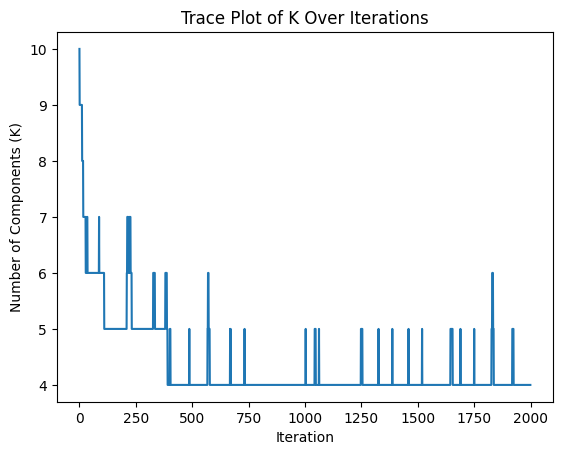

In [42]:
import matplotlib.pyplot as plt

plt.plot(range(Niter), mcmc["K"])
plt.xlabel("Iteration")
plt.ylabel("Number of Components (K)")
plt.title("Trace Plot of K Over Iterations")
plt.show()

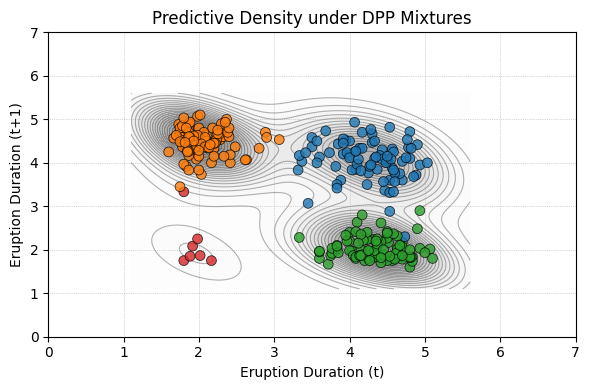

In [43]:
import seaborn as sns
from scipy.stats import multivariate_normal, gaussian_kde

# Setup Grid
xgrid = np.linspace(y[:, 0].min() - 0.5, y[:, 0].max() + 0.5, 200)
ygrid = np.linspace(y[:, 1].min() - 0.5, y[:, 1].max() + 0.5, 200)
X, Y = np.meshgrid(xgrid, ygrid)
positions = np.vstack([X.ravel(), Y.ravel()]) 

# Base Density Using KDE
kde = gaussian_kde(y.T)
density = kde(positions).reshape(X.shape)

# Predictive Density from DPP (Last MCMC Sample)
p_pred_DPP = np.zeros(X.shape)

iter = -1  # Use the last iteration
K_final = mcmc["K"][iter]
mu_final = mcmc["mu"][iter, :K_final, :]
lambda_final = mcmc["lambda"][iter, :K_final, :]
z_final = mcmc["z"][iter, :]

for k in range(K_final):
    cov_k = np.diag(1 / lambda_final[k]) 
    rv = multivariate_normal(mean=mu_final[k], cov=cov_k)
    p_pred_DPP += rv.pdf(np.dstack((X, Y)))

# Plot Contour and Clustered Data
plt.figure(figsize=(6, 4))

# Contour density (background from KDE)
plt.contourf(X, Y, density, levels=30, cmap="Greys", alpha=0.5)
plt.contour(X, Y, density, levels=30, colors="grey", linewidths=0.8, alpha=0.6)


# Scatterplot
palette = sns.color_palette("husl", K_final)
sns.scatterplot(x=y[:, 0], y=y[:, 1], hue=z_final, palette="tab10", edgecolor="black", alpha=0.8, zorder=3, s=50, legend=False)

# Labels & Formatting
plt.xlim(0, 7)
plt.ylim(0, 7)
plt.xlabel("Eruption Duration (t)")
plt.ylabel("Eruption Duration (t+1)")
plt.title("Predictive Density under DPP Mixtures")
plt.grid(True, linestyle=":", linewidth=0.5)
plt.tight_layout()


plt.show()

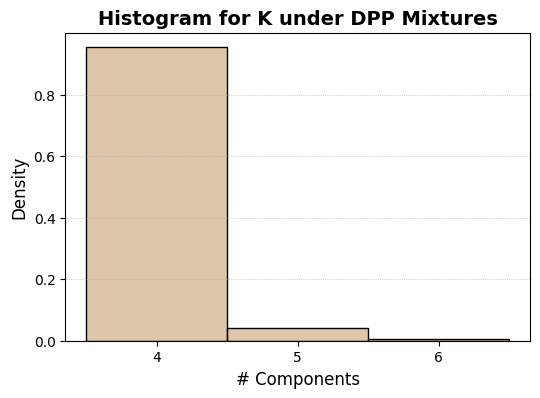

In [44]:
# Extract the number of components (K) across all MCMC iterations
burn_in = 1000  
K_samples = mcmc["K"][burn_in:]  # Use only post burn-in samples

# Create histogram
plt.figure(figsize=(6, 4))
sns.histplot(K_samples, bins=np.arange(min(K_samples)-0.5, max(K_samples)+1.5, 1), 
             stat="density", color="tan", edgecolor="black")

plt.xlabel("# Components", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.title("Histogram for K under DPP Mixtures", fontsize=14, fontweight="bold")
plt.xticks(range(min(K_samples), max(K_samples) + 1))
plt.yticks(np.linspace(0, 0.8, 5))
plt.grid(axis="y", linestyle=":", linewidth=0.5)
plt.show()


Figure (d) shows that the DPP mixture model also centers around K = 4. This shows a general agreement with the correct cluster count. However, compared to RGM, the DPP posterior exhibits a slightly larger spread, suggesting marginally more uncertainty. This reflects the DPP model's tendency to be somewhat more flexible, though still relatively concentrated.

## DPM Mixture Model

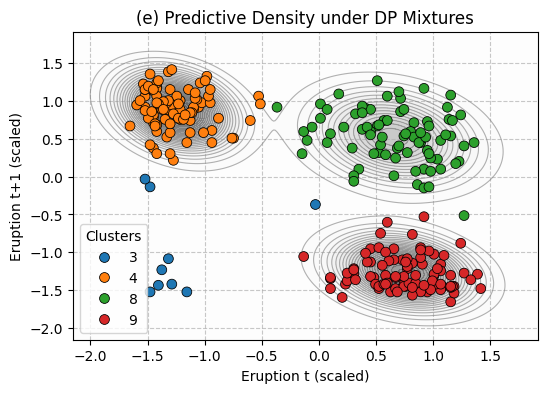

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import BayesianGaussianMixture
from sklearn.preprocessing import StandardScaler

X = df.values  
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit a baseline DPGMM
dpgmm = BayesianGaussianMixture(
    n_components=10,
    covariance_type="full",
    weight_concentration_prior_type="dirichlet_process",
    weight_concentration_prior=1e-2,
    max_iter=1000,
    random_state=42
)
dpgmm.fit(X_scaled)
labels = dpgmm.predict(X_scaled)
num_clusters = len(np.unique(labels))

# Monte Carlo estimation of number of clusters K
num_clusters_samples = []
num_runs = 50
for _ in range(num_runs):
    alpha_sample = np.random.uniform(0.01, 3.0)
    noise = np.random.normal(0, 0.1, X_scaled.shape)

    dpgmm_sampled = BayesianGaussianMixture(
        n_components=10,
        covariance_type="full",
        weight_concentration_prior_type="dirichlet_process",
        weight_concentration_prior=alpha_sample,
        max_iter=1000,
        random_state=np.random.randint(10000)
    )
    dpgmm_sampled.fit(X_scaled + noise)
    prob_clusters = dpgmm_sampled.predict_proba(X_scaled + noise)
    sampled_labels = np.argmax(np.cumsum(prob_clusters, axis=1) > np.random.rand(*prob_clusters.shape), axis=1)
    num_clusters_samples.append(len(np.unique(sampled_labels)))

# Predict cluster assignments
labels = dpgmm.predict(X_scaled)
num_clusters = len(np.unique(labels))  # Number of unique clusters found

# Generate a grid for contour plot
x = np.linspace(X_scaled[:, 0].min() - 0.5, X_scaled[:, 0].max() + 0.5, 300)
y = np.linspace(X_scaled[:, 1].min() - 0.5, X_scaled[:, 1].max() + 0.5, 300)
Xgrid, Ygrid = np.meshgrid(x, y)
XX = np.array([Xgrid.ravel(), Ygrid.ravel()]).T 

# Evaluate the predictive density
log_density = dpgmm.score_samples(XX)
Z = np.exp(log_density).reshape(Xgrid.shape)

# Plot Contour and Clustered Data
plt.figure(figsize=(6,4))

# Contour density (background from KDE)
plt.contourf(Xgrid, Ygrid, Z, levels=30, cmap="Greys", alpha=0.5)
plt.contour(Xgrid, Ygrid, Z, levels=30, colors="grey", linewidths=0.8, alpha=0.6)

# Scatterplot
palette = sns.color_palette("husl", num_clusters)
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=labels, palette="tab10", edgecolor='black', s=50, zorder = 3)

# Labels and Formatting
plt.xlabel('Eruption t (scaled)')
plt.ylabel('Eruption t+1 (scaled)')
plt.title('(e) Predictive Density under DP Mixtures')
plt.legend(title="Clusters")
plt.grid(True, linestyle="dashed", alpha=0.7)

# Show plot
plt.show()

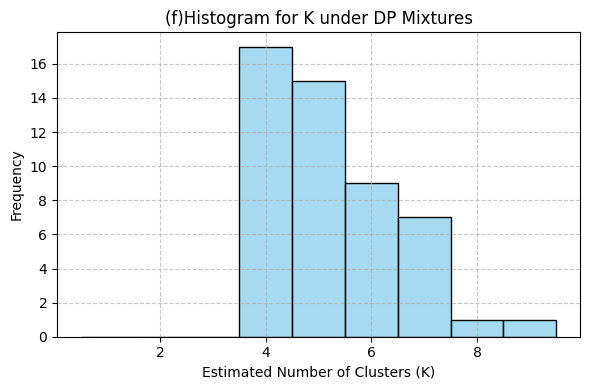

In [11]:
plt.figure(figsize=(6, 4))
sns.histplot(num_clusters_samples, bins=np.arange(1, max(num_clusters_samples)+2)-0.5, kde=False, color="skyblue", edgecolor="black")
plt.xlabel("Estimated Number of Clusters (K)")
plt.ylabel("Frequency")
plt.title("(f)Histogram for K under DP Mixtures")
plt.grid(True, linestyle="dashed", alpha=0.7)
plt.tight_layout()
plt.show()


As seen in Figure (f), the DP mixture model results in the most diffuse posterior over K. The distribution spans a wide range of cluster counts, with noticeable support for values from 4 up to 8. This illustrates the inherent flexibility and non-repulsive nature of the DP prior, often leading to overestimation of the number of components and greater variability across Monte Carlo samples.

## Conclusion

Among the three models:

- RGM achieves the most precise and accurate estimate of K, with a highly concentrated posterior.

- DPP performs comparably but shows a slightly wider spread in its estimates.

- DP is the least certain, producing a broad and overdispersed estimate of the number of clusters.

These results affirm that the proposed RGM model surpasses the other two approaches in both robustness and model simplicity, as reflected by the concentration of the posterior distribution over K.